In [60]:
import torch
from  torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import os
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import itertools
writer = SummaryWriter()

In [61]:
class stl10_dataset(torch.utils.data.Dataset):

    def __init__(self, text_file, root_dir, transform):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.name_frame = pd.read_csv(text_file,sep=" ",usecols=range(1))         
        self.label_frame = pd.read_csv(text_file,sep=" ",usecols=range(1,2))       
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.name_frame.iloc[idx, 0])
        image = Image.open(img_name)
        image = self.transform(image)
        labels = self.label_frame.iloc[idx, 0]

        return image,labels

data_transform = transforms.Compose([ transforms.Resize((32,32)), transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0,0,0], std=[1,1,1])])

trainSet = stl10_dataset(text_file ='splits/train.txt', root_dir = '', transform=data_transform)
stl10_TrainLoader = torch.utils.data.DataLoader(trainSet, batch_size=16, shuffle=True)


In [62]:
# Find mean and standard deviation for the data.

def compute_mean_std(image_set, image_loader):

    psum    = torch.tensor([0.0, 0.0, 0.0])             
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images and find mean 
    for inputs,_ in tqdm(image_loader):
        psum    += inputs.sum(axis = [0, 2, 3])     
        psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

    # pixel count in a batch
    count = len(image_set) * 32 * 32

    # mean and std dev calculations
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # print data stats 
    print('mean: '  + str(total_mean))
    print('std:  '  + str(total_std))
    return total_mean, total_std
   
# compute mean and standard deviation
train_mean, train_std = compute_mean_std(trainSet, stl10_TrainLoader)

100%|█████████████████████████████████████████| 313/313 [00:10<00:00, 30.40it/s]

mean: tensor([0.4468, 0.4399, 0.4067])
std:  tensor([0.2419, 0.2384, 0.2541])


In [63]:
#re-load the train test and val data with newly calculated mean and std dev

data_transform2 = transforms.Compose([ transforms.Resize((32,32)), transforms.ToTensor(), 
                                     transforms.Normalize(mean=train_mean, std=train_std)])


trainSet = stl10_dataset(text_file ='splits/train.txt', root_dir = '', transform=data_transform2)
testSet = stl10_dataset(text_file ='splits/test.txt', root_dir = '', transform=data_transform2)
valSet = stl10_dataset(text_file ='splits/val.txt', root_dir = '', transform=data_transform2)

stl10_TrainLoader = torch.utils.data.DataLoader(trainSet, batch_size=128, shuffle=True)
stl10_TestLoader = torch.utils.data.DataLoader(testSet, batch_size=1, shuffle=True)
stl10_ValLoader = torch.utils.data.DataLoader(valSet, batch_size=1, shuffle=True)

   



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 3, 3, 6, 6, 9, 0, 9, 1, 4, 5, 1, 6, 2, 5, 5, 2, 0, 3, 8, 1, 8, 1, 4,
        2, 0, 5, 8, 0, 9, 1, 7, 3, 3, 8, 4, 0, 2, 7, 8, 7, 1, 2, 1, 7, 5, 4, 3,
        8, 8, 7, 0, 2, 4, 2, 7, 6, 6, 1, 5, 6, 2, 0, 3, 1, 5, 6, 0, 3, 8, 3, 6,
        1, 9, 5, 4, 6, 6, 4, 2, 9, 3, 7, 1, 1, 4, 3, 9, 3, 4, 7, 2, 3, 9, 0, 1,
        8, 2, 2, 9, 1, 1, 7, 0, 5, 4, 5, 3, 1, 8, 8, 1, 1, 9, 1, 9, 8, 6, 5, 7,
        1, 8, 3, 9, 3, 7, 8, 9])


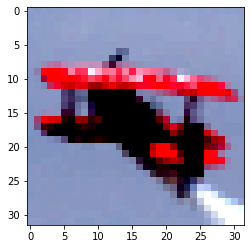

In [64]:
#plotting sample image
dataiter = iter(stl10_TrainLoader)
images, labels = dataiter.next()
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
print(labels)


In [65]:
#lenet5 with batch normalization 

class LeNet5_bn(nn.Module):
    def __init__(self):
        super(LeNet5_bn, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, stride = 1, kernel_size=(5,5))
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, stride = 1, kernel_size=(5,5))
        self.conv2_bn = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(400, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv1_bn(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_bn(x)
        x = self.pool2(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc1_bn(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_bn(x)
        x = self.fc3(x)
        return x                   

In [66]:
#lenet5 
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, stride = 1, kernel_size=(5,5))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, stride = 1, kernel_size=(5,5))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(400, 120)             
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [67]:
# multi-class accuracy function 

def multi_accuracy(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [68]:
def train(model, epochs, criterion, optimizer, scheduler,model_name=""):
    model.train()
    min_valid_loss = float("inf")
    
    for epoch in range(1,epochs+1):  # loop over the dataset multiple times
        running_loss = 0.0
        running_accuracy = 0
        
        for i, data in enumerate(stl10_TrainLoader, 0):
            batch_loss = 0
            batch_accuracy = 0
            
            inputs, labels = data    # get the inputs; data is a list of [inputs, labels]
            
            optimizer.zero_grad()    # zero the parameter gradients

            
            outputs = model(inputs)  # forward + backward + optimize
            loss = criterion(outputs, labels) # calculate loss
            loss.backward()                   # accumulate gradient
            optimizer.step()                  # update weights

            # add statistics calculated
            running_loss += loss.item()
            running_accuracy += multi_accuracy(outputs,labels)
            batch_loss += loss.item()
            batch_accuracy += multi_accuracy(outputs,labels)
            
            # log statistics on tensorboard
            writer.add_scalars(model_name+' batch_step_loss', {'training loss':(batch_loss/len(data))}, epoch)
            writer.add_scalars(model_name+' batch_step_accuracy', {'training accuracy':(batch_accuracy/len(data))}, epoch)
            
        
        # advance the scheduler for lr decay
        scheduler.step()
        
        
        # calculate loss and accuracy on validation set
        r_valid_loss = 0.0
        r_valid_accuracy = 0
        model.eval()
        for data, labels in stl10_ValLoader:
            target = model(data)
            loss = criterion(target,labels)
            r_valid_loss += loss.item() 
            r_valid_accuracy += multi_accuracy(target, labels) 
            
        
        #print Loss and Accuracy every 5 epochs    
        if epoch%5 ==0:   
            print("Epoch", epoch," Training Loss", running_loss/len(stl10_TrainLoader)," Training Accuracy", running_accuracy/len(stl10_TrainLoader))
            print("Epoch", epoch," Validation Loss", r_valid_loss/len(stl10_ValLoader)," Validation Accuracy", r_valid_accuracy/len(stl10_ValLoader))
       
        # log training vs validation loss and accuracy 
        writer.add_scalars(model_name+' loss', {'training loss':(running_loss/len(stl10_TrainLoader)),'validation loss':(r_valid_loss/len(stl10_ValLoader))}, epoch)
        writer.add_scalars(model_name+' accuracy', {'training accuracy':(running_accuracy/len(stl10_TrainLoader)),'validation accuracy':(r_valid_accuracy/len(stl10_ValLoader))}, epoch)
        
    print('Finished Training')
    return model

In [69]:
# print class wise accuracy 

def print_class_wise_acc(cm, model_name):
    print("Accuracy by each class for {}".format(model_name))
    accuracy_multiclass = []
    index = 0
    for row in cm:
        accuracy_multiclass.append([index+1, (row[index]/sum(row))*100])
        index += 1
    df = pd.DataFrame(accuracy_multiclass, columns=['class', 'accuracy'])
    print(df)

In [70]:
def evaluate_model(model,model_name=""):
    model.eval()

    y_pred_list = []
    y_test_list = []
    correct_pred = 0
    failed_dict = {}

    with torch.no_grad():
        for X_batch, y_batch in stl10_TestLoader:            # loop through the test batch
            X_batch = X_batch.type(torch.FloatTensor)        # convert to tensor
            y_batch.type(torch.FloatTensor)
            y_test_pred = model(X_batch)                     # get prediction
            
            y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    # get class tag
            
            y_pred_list.append(y_pred_tags.item())           
            
            y_test_list.append(y_batch.item())
            if y_batch != y_pred_tags:                       # save one example of each wrongly predicted class 
                if y_batch.item() not in failed_dict:
                    failed_dict[y_batch.item()] = (X_batch, y_pred_tags)
            
            correct_pred += multi_accuracy(y_test_pred, y_batch)
        print(correct_pred.item()/len(stl10_TestLoader))
        
        
        y_test_list, y_pred_list = np.array(y_test_list), np.array(y_pred_list) 
        y_unique = np.array([1,2,3,4,5,6,7,8,9,10])          # unique label names for confusion matrix plot
        cm = confusion_matrix(y_test_list, y_pred_list)      # sklearn's confusion matrix
        
        plot_confusion_matrix(cm, y_unique,title=model_name) # plot confusion matrix
        print_class_wise_acc(cm, model_name)                 # print classwise accuracy 
        
        # plot misclassified images 
        
        i=0
        fig, axs = plt.subplots(2, 5, figsize=(25, 10))
        failed_dict = dict(sorted(failed_dict.items()))
        for label, (image, pred) in failed_dict.items():
            image = torch.squeeze(image, axis=0)            
            
            if i<5:  
                axs[0, i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
                axs[0, i].set_title("label:"+str(label+1)+" pred:"+str(pred.item()+1))
            else:
                axs[1, i-5].imshow(np.transpose(image.numpy(), (1, 2, 0)))
                axs[1, i-5].set_title("label:"+str(label+1)+" pred:"+str(pred.item()+1))
                
            i+=1

        

In [71]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# lenet5 main experiment

In [72]:
lenet = LeNet5()  
EPOCHS = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
lenet = train(lenet, EPOCHS, criterion, optimizer, scheduler,model_name="lenet5")
writer.flush()

Epoch 5  Training Loss 1.575697299838066  Training Accuracy tensor(40.7750)
Epoch 5  Validation Loss 1.5698190864123387  Validation Accuracy tensor(40.1801)
Epoch 10  Training Loss 1.3818290472030639  Training Accuracy tensor(47.8250)
Epoch 10  Validation Loss 1.4684835151305267  Validation Accuracy tensor(44.9817)
Epoch 15  Training Loss 1.2527966618537902  Training Accuracy tensor(53.5250)
Epoch 15  Validation Loss 1.4814216553644415  Validation Accuracy tensor(45.6485)
Epoch 20  Training Loss 1.1106121674180032  Training Accuracy tensor(58.4500)
Epoch 20  Validation Loss 1.4325014029500225  Validation Accuracy tensor(47.8826)
Epoch 25  Training Loss 0.9411104649305344  Training Accuracy tensor(66.3250)
Epoch 25  Validation Loss 1.4308740707124026  Validation Accuracy tensor(49.6499)
Epoch 30  Training Loss 0.8682149231433869  Training Accuracy tensor(69.1250)
Epoch 30  Validation Loss 1.476574780098051  Validation Accuracy tensor(49.3164)
Epoch 35  Training Loss 0.7914263606071472  

48.32966593318664


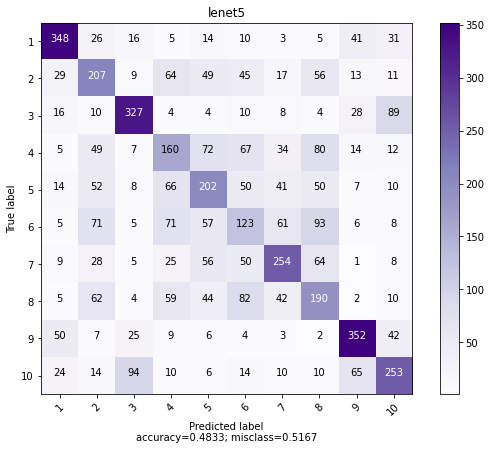

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy by each class for lenet5
   class   accuracy
0      1  69.739479
1      2  41.400000
2      3  65.400000
3      4  32.000000
4      5  40.400000
5      6  24.600000
6      7  50.800000
7      8  38.000000
8      9  70.400000
9     10  50.600000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


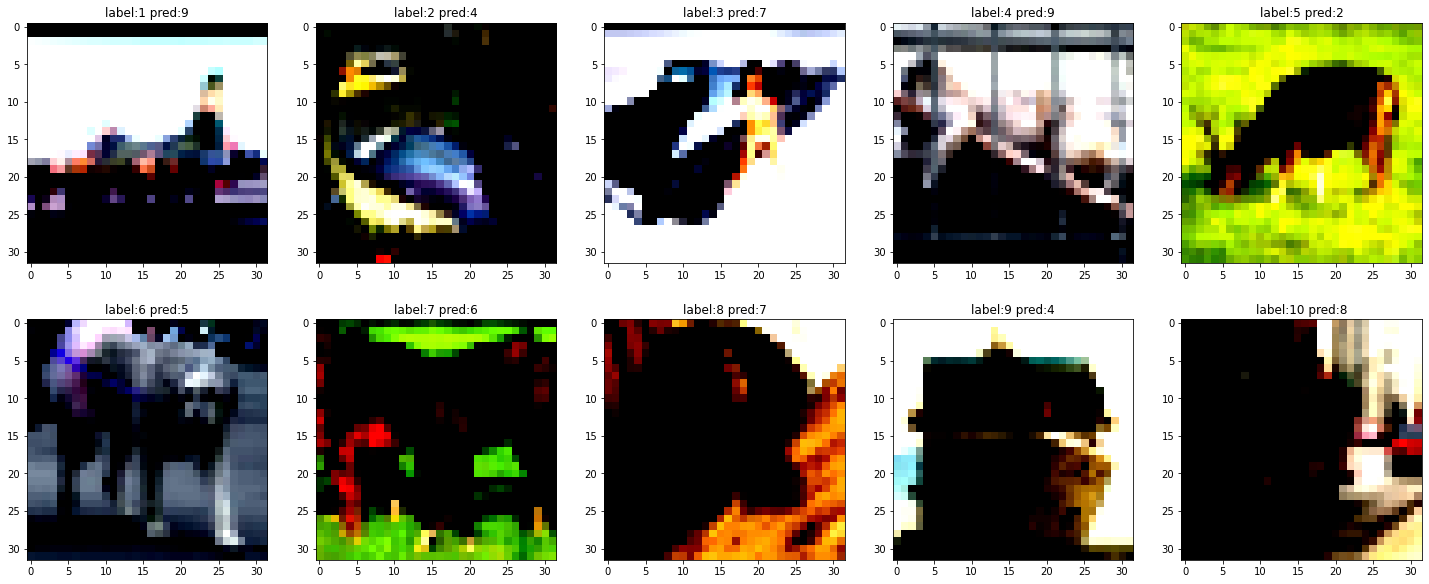

In [73]:
evaluate_model(lenet, model_name="lenet5")

# lenet5 with l2 regularization

In [74]:
lenet_l2 = LeNet5()  
EPOCHS = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_l2.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
lenet_l2 = train(lenet_l2, EPOCHS, criterion, optimizer, scheduler, model_name ="lenet5_l2_regularization")
writer.flush()

Epoch 5  Training Loss 1.6420347273349762  Training Accuracy tensor(37.5750)
Epoch 5  Validation Loss 1.708211713826713  Validation Accuracy tensor(36.2454)
Epoch 10  Training Loss 1.4685825616121293  Training Accuracy tensor(44.8250)
Epoch 10  Validation Loss 1.587516279833372  Validation Accuracy tensor(40.7803)
Epoch 15  Training Loss 1.3916505768895149  Training Accuracy tensor(48.3000)
Epoch 15  Validation Loss 1.5191796361411283  Validation Accuracy tensor(44.2481)
Epoch 20  Training Loss 1.2978912353515626  Training Accuracy tensor(51.2250)
Epoch 20  Validation Loss 1.4379625811569037  Validation Accuracy tensor(46.9823)
Epoch 25  Training Loss 1.1904519021511077  Training Accuracy tensor(56.1000)
Epoch 25  Validation Loss 1.4550223189659326  Validation Accuracy tensor(45.8486)
Epoch 30  Training Loss 1.1166773736476898  Training Accuracy tensor(58.2000)
Epoch 30  Validation Loss 1.4283744809205912  Validation Accuracy tensor(47.4825)
Epoch 35  Training Loss 1.0651883035898209  

48.60972194438888


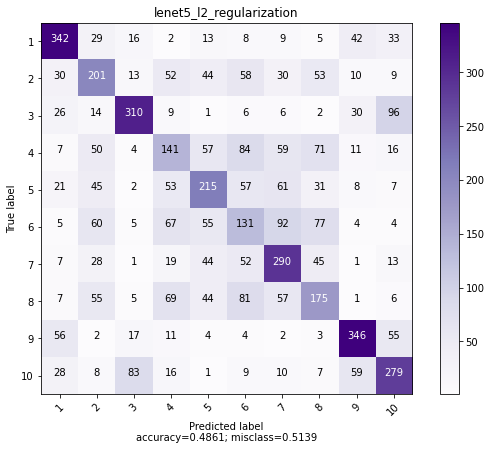

Accuracy by each class for lenet5_l2_regularization
   class   accuracy
0      1  68.537074
1      2  40.200000
2      3  62.000000
3      4  28.200000
4      5  43.000000
5      6  26.200000
6      7  58.000000
7      8  35.000000
8      9  69.200000
9     10  55.800000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

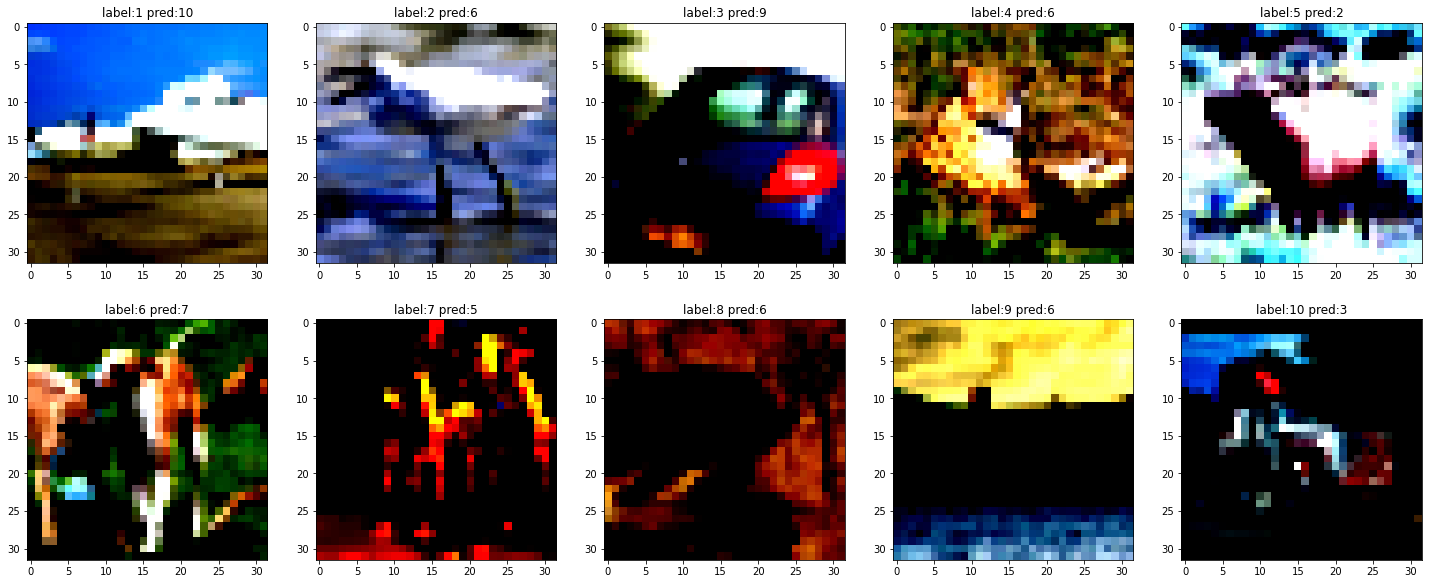

In [75]:
evaluate_model(lenet_l2, model_name ="lenet5_l2_regularization")

# lenet5 with batch normalization

In [76]:
lenet_bn = LeNet5_bn()
EPOCHS = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_bn.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
lenet = train(lenet_bn, EPOCHS, criterion, optimizer, scheduler, model_name="lenet5_batch_norm")
writer.flush()

Epoch 5  Training Loss 1.0169735640287398  Training Accuracy tensor(64.2750)
Epoch 5  Validation Loss 1.5002265332678877  Validation Accuracy tensor(48.2828)
Epoch 10  Training Loss 0.4304424747824669  Training Accuracy tensor(86.5750)
Epoch 10  Validation Loss 1.9248181056759333  Validation Accuracy tensor(47.4825)
Epoch 15  Training Loss 0.06895617498084902  Training Accuracy tensor(98.9500)
Epoch 15  Validation Loss 2.852661964290283  Validation Accuracy tensor(46.7156)
Epoch 20  Training Loss 0.007315184199251234  Training Accuracy tensor(100.)
Epoch 20  Validation Loss 3.4910287384480845  Validation Accuracy tensor(47.5492)
Epoch 25  Training Loss 0.0029795408278005197  Training Accuracy tensor(100.)
Epoch 25  Validation Loss 3.7111832981714694  Validation Accuracy tensor(48.0494)
Epoch 30  Training Loss 0.0019057502591749652  Training Accuracy tensor(100.)
Epoch 30  Validation Loss 3.886864897923908  Validation Accuracy tensor(47.9493)
Epoch 35  Training Loss 0.001390795377665199

47.289457891578316


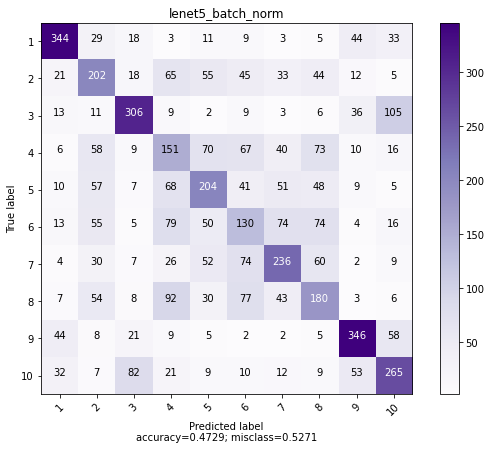

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy by each class for lenet5_batch_norm
   class   accuracy
0      1  68.937876
1      2  40.400000
2      3  61.200000
3      4  30.200000
4      5  40.800000
5      6  26.000000
6      7  47.200000
7      8  36.000000
8      9  69.200000
9     10  53.000000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


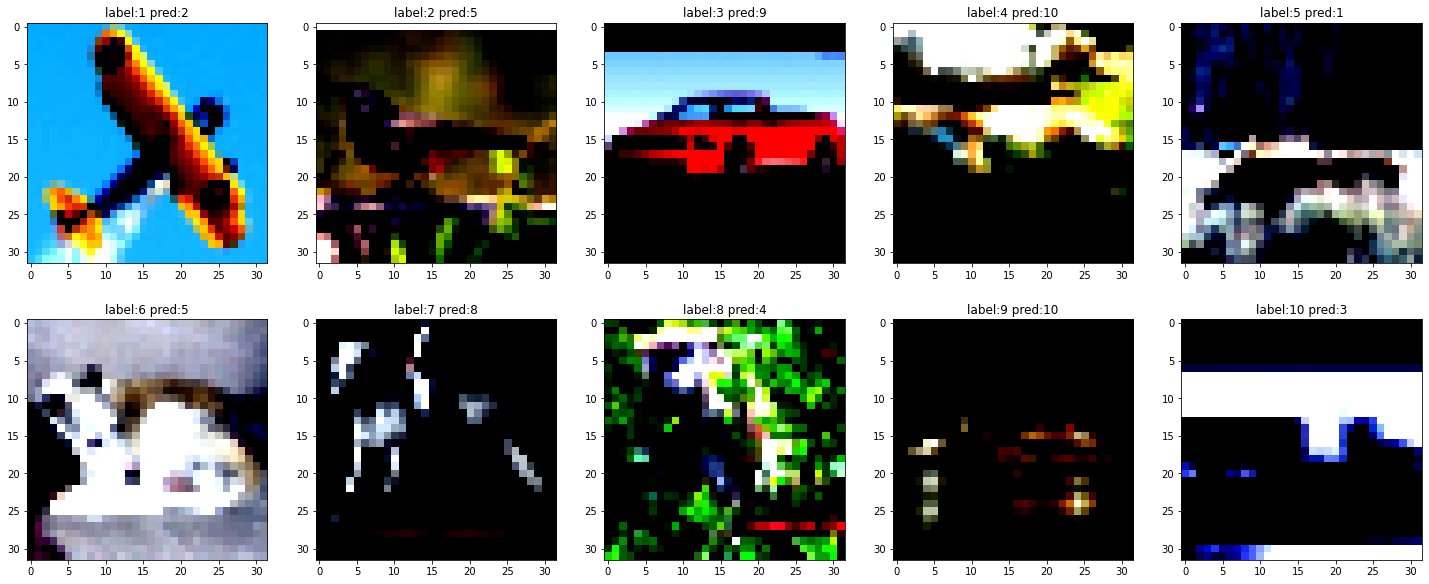

In [77]:
evaluate_model(lenet_bn, model_name="lenet5_batch_norm")

# Accuracies for each model 

Lenet5 Model:
48.32966593318664

Lenet5 l2 Regularization Model:
48.60972194438888

Lenet5 Batch Normalization Model:
47.289457891578316